# Feature extraction

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from main import PreProcessing, Statistics    # import the main.py file

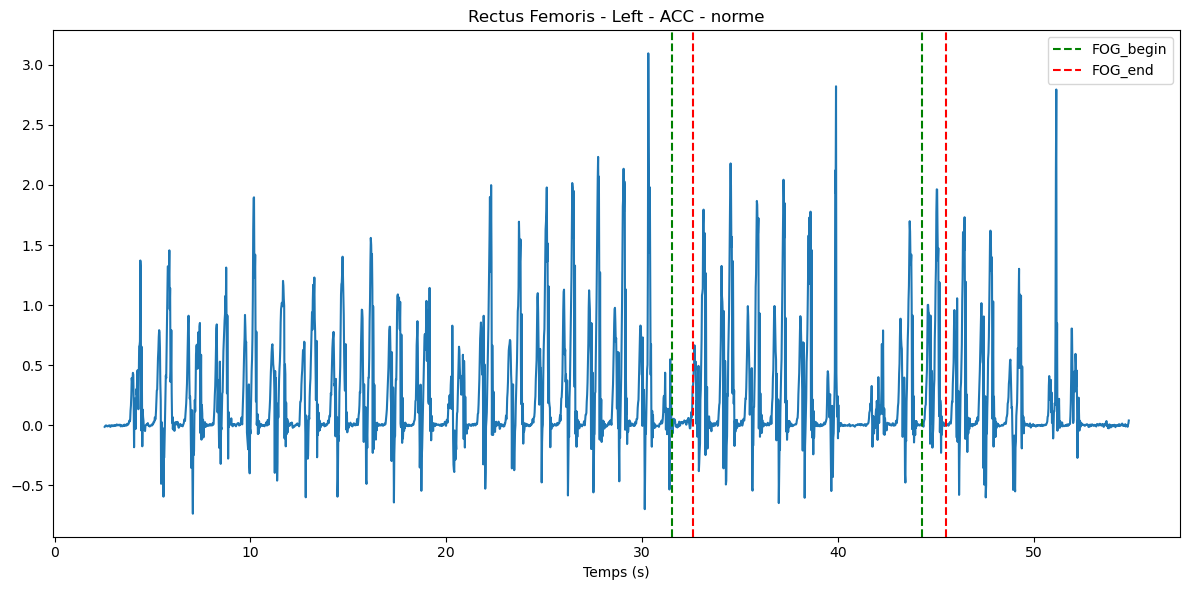

In [4]:
file_path = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATA_FOG/LE_LIEVRE_Emmanuel_1971_03_19_LEEM1971/2023-05-26/2023-05-26_overlay_detectFOG/Video overlay 15.c3d"
# Définir les informations du patient
patient_id = 1234
date_de_naissance = "1963-06-23"
medicaments = "Traitement X"
# Instancier l'objet DetectFog
detector = PreProcessing(file_path)
detector.creation_json_grace_c3d(patient_id, date_de_naissance, medicaments)
detector.extract_data_interval()
detector.plot_data_FOG_start_end("Rectus Femoris", "Left", "ACC", "norme")
detector.normalize_data() 
detector.decoupage_en_fenetres()
detector.label_fenetre()
detector.association_label_fenetre_data()
data = detector.concat_label_fenetre_data()

Attention le code le labelisation des fenêtre ne foncitonne pas quand il y a plusieurs FOG consécutifs ne moins de 1 ou 2 secondes

In [3]:
a = data["Rectus Femoris"]["Left"]["ACC"]["norme"]
fog = data["FOG"]
print(fog)

{'debut': [31.50666618347168, 44.28666687011719], 'fin': [32.606666564941406, 45.526668548583984]}


# Extraction des caractéristiques

# Création de la classe cible (fog et transitionFog) et non cible

In [38]:
def filter_data_by_label(data, label):
    filtered_data = {}

    # Bouclez à travers les données pour chaque muscle, côté, capteur, axe
    for muscle, muscle_data in data.items():
        if muscle not in ["metadata", "parcours", "FOG"]:
            filtered_data[muscle] = {}
            for side, side_data in muscle_data.items():
                filtered_data[muscle][side] = {}
                for sensor, sensor_data in side_data.items():
                    filtered_data[muscle][side][sensor] = {}
                    for axis, axis_data in sensor_data.items():
                        # Filtrer les données pour ne conserver que les lignes avec le label spécifié
                        filtered_df = axis_data[axis_data['label'] == label]
                        # Stockez le DataFrame filtré dans le dictionnaire
                        filtered_data[muscle][side][sensor][axis] = filtered_df

    return filtered_data

In [64]:
def filter_data_by_label(data, target_labels):
    target = {}
    noTarget = {}
    # Bouclez à travers les données pour chaque muscle, côté, capteur, axe
    for muscle, muscle_data in data.items():
        if muscle not in ["metadata", "parcours", "FOG"]:
            target[muscle] = {}
            noTarget[muscle] = {}
            for side, side_data in muscle_data.items():
                target[muscle][side] = {}
                noTarget[muscle][side] = {}
                for sensor, sensor_data in side_data.items():
                    target[muscle][side][sensor] = {}
                    noTarget[muscle][side][sensor] = {}
                    for axis, axis_data in sensor_data.items():
                        # Filtrer les données pour ne conserver que les lignes avec les labels spécifiés
                        target_df = axis_data[axis_data['label'].isin(target_labels)]
                        noTarget_df = axis_data[~axis_data['label'].isin(target_labels)]  # Utilisez ~ pour sélectionner les valeurs qui ne sont pas dans target_labels
                        # Stockez le DataFrame filtré dans le dictionnaire
                        target[muscle][side][sensor][axis] = target_df
                        noTarget[muscle][side][sensor][axis] = noTarget_df

    return target, noTarget


In [65]:
target, noTarget = filter_data_by_label(data, ['fog', 'transitionFog'])

In [66]:
rectus_target = target["Rectus Femoris"]["Left"]["ACC"]["norme"]
rectus_noTarget = noTarget["Rectus Femoris"]["Left"]["ACC"]["norme"]